# Data preparation

Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import truncnorm, beta, norm, uniform
import matplotlib.pyplot as plt
import os
import json

## Read and prepare data

### Read data

In [2]:
paradigm = 'FLA'
case = 'RE'

data_path = f'data/beh_eeg_{paradigm}/{paradigm}/preprocessed/wavelets_th-045/'
data_df = pd.DataFrame()

id_list = [item.split('.')[0] for item in os.listdir(data_path)]

for participant_id in id_list:
    participant_data_df = pd.read_pickle(f'{data_path}{participant_id}.pkl')
    participant_data_df['ID'] = participant_id.split("_")[1]
    
    # Create a DataFrame with the complete range of trial indices (1 to 300)
    complete_trials = pd.DataFrame({'trial number': range(1, 301), 'ID': [participant_id.split("_")[1]]*300})

    # Merge the original DataFrame with the complete_trials DataFrame
    merged_df = pd.merge(complete_trials, participant_data_df, on=['trial number', 'ID'], how='left')
    
    data_df = pd.concat([data_df, merged_df], ignore_index=True)

### Featurize ERN: peak amplitude at FCz
- EEG column in bad trials will be filled with NaN

In [3]:
channel = 'FCz'

data_df[f'ne_{channel}'] = data_df.apply(
    lambda row: np.nan if pd.isna(row['drop_log']) or channel in row['drop_log'] else np.min(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()),
    axis=1
)

data_df[f'ne_mean_{channel}'] = data_df.apply(
    lambda row: np.nan if pd.isna(row['drop_log']) or channel in row['drop_log'] else np.mean(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()),
    axis=1
)

channel = 'Fz'

data_df[f'ne_{channel}'] = data_df.apply(
    lambda row: np.nan if pd.isna(row['drop_log']) or channel in row['drop_log'] else np.min(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()),
    axis=1
)

data_df[f'ne_mean_{channel}'] = data_df.apply(
    lambda row: np.nan if pd.isna(row['drop_log']) or channel in row['drop_log'] else np.mean(row['epoch'].get_data(picks=channel, tmin=0.0, tmax=0.1).flatten()),
    axis=1
)

In [4]:
# drop column with epochs to better display df
columns_to_drop = ['epoch']
data_df = data_df.drop(columns=columns_to_drop)

### Mark bad participants (less than 6 trials)

In [5]:
cleared_data_df = data_df.copy(deep=True)

ids = np.unique(data_df['ID'])
n_clear_trails = 6

for participant_id in ids:
    participant_data = data_df[data_df['ID'] == participant_id]['ne_FCz'].to_numpy()
    good_trials = np.count_nonzero(~np.isnan(participant_data.flatten()))
    
    if good_trials < n_clear_trails:
        print(f"Participant {participant_id} has {good_trials} good trial. Rejecting")
        cleared_data_df = cleared_data_df[cleared_data_df['ID'] != participant_id]        
    
cleared_data_df = cleared_data_df.reset_index()
cleared_ids = np.unique(cleared_data_df['ID'])

Participant FLA-222 has 0 good trial. Rejecting


### Mark participants who have less than 6 error trials

In [6]:
ids = np.unique(cleared_data_df['ID'])
n_error = 6

for participant_id in ids:
    participant_data = cleared_data_df[cleared_data_df['ID'] == participant_id]
    error_trials = participant_data[(participant_data['reaction'] == 'incorrect') & 
                                    (participant_data['ne_FCz'].notna())]
    
    print(len(error_trials))

    if len(error_trials) < n_error:
        print(f"Participant {participant_id} has {len(error_trials)} erroneous trial. Rejecting")
        cleared_data_df = cleared_data_df[cleared_data_df['ID'] != participant_id]

cleared_data_df = cleared_data_df.reset_index()
cleared_ids = np.unique(cleared_data_df['ID'])

41
26
12
14
57
61
39
19
39
49
18
27
68
11
56
34
30
43
32
23
1
Participant FLA-020 has 1 erroneous trial. Rejecting
10
22
47
24
8
21
18
13
45
29
28
8
17
33
67
52
31
32
26
44
38
35
39
38
10
16
39
29
33
30
18
29
45
31
11
15
34
15
26
48
14
31
22
21
49
54
22
29
82
34
52
38
27
39
22
31
39
24
45
35
25
30
31
31
66
31
50
54
36
43
32
25
24
16
39
37
82
67
55
39
33
53
37
22
35
40
11
33
30
80
64
31
23
29
42
23
13
40
19
14
10
29
42
5
Participant FLA-124 has 5 erroneous trial. Rejecting
26
23
27
31
24
27
76
27
18
37
44
28
40
34
27
33
27
27
52
53
50
29
38
34
62
26
24
38
75
50
15
69
73
33
41
31
25
35
22
33
37
38
39
18
43
68
28
16
27
27
25
66
31
20
58
41
24
32
50
45
27
32
49
48
51
23
20
48
31
42
28
69
9
28
57
35
22
16
13
36
47
48
26
30
28
20
73
46
24
24
48
25
32
10
29
10
28
23
24


In [7]:
cleared_data_df

level_0  index  trial number       ID  block_type   trial_type  \
0            0      0             1  FLA-169  experiment    congruent   
1            1      1             2  FLA-169  experiment    congruent   
2            2      2             3  FLA-169  experiment  incongruent   
3            3      3             4  FLA-169  experiment    congruent   
4            4      4             5  FLA-169  experiment  incongruent   
...        ...    ...           ...      ...         ...          ...   
66595    67195  67495           296  FLA-170  experiment  incongruent   
66596    67196  67496           297  FLA-170  experiment    congruent   
66597    67197  67497           298  FLA-170  experiment  incongruent   
66598    67198  67498           299  FLA-170  experiment    congruent   
66599    67199  67499           300  FLA-170  experiment  incongruent   

       cue_name      target_name response        rt  ... target_show_time  \
0           NaN    congruent_lll        l  0.268716  ...              0.6   
1           NaN    congruent_lll        l  0.309487  ...              0.6   
2           NaN  incongruent_rlr        l  0.397239  ...              0.6   
3           NaN    congruent_rrr        r  0.309485  ...              0.6   
4           NaN  incongruent_lrl        r  0.386673  ...              0.6   
...         ...              ...      ...       ...  ...              ...   
66595       NaN  incongruent_rlr        r  0.260115  ...              0.6   
66596       NaN    congruent_rrr        r  0.292400  ...              0.6   
66597       NaN  incongruent_lrl        r  0.400546  ...              0.6   
66598       NaN    congruent_lll        l  0.250364  ...              0.6   
66599       NaN  incongruent_lrl        l  0.237299  ...              0.6   

       empty_screen_after_response_show_time  feedback_show_time  \
0                                        1.0                 0.8   
1                                        1.0                 0.8   
2                                        1.0                 0.8   
3                                        1.0                 0.8   
4                                        1.0                 0.8   
...                                      ...                 ...   
66595                                    1.0                 0.8   
66596                                    1.0                 0.8   
66597                                    1.0                 0.8   
66598                                    1.0                 0.8   
66599                                    1.0                 0.8   

       feedback_type  event  drop_log        ne_FCz  ne_mean_FCz  \
0      feedback_good      2        () -1.392086e-05    -0.000005   
1      feedback_good      2        () -2.783326e-06     0.000009   
2       feedback_bad      0        () -3.684688e-06     0.000003   
3      feedback_good      2        ()  7.475740e-07     0.000006   
4       feedback_bad      0        () -5.791032e-06    -0.000002   
...              ...    ...       ...           ...          ...   
66595            NaN      1     (P2,) -1.820390e-05    -0.000011   
66596   feedback_bad      2     (P2,) -1.453992e-05    -0.000005   
66597   feedback_bad      0     (P2,) -1.705890e-06     0.000003   
66598   feedback_bad      2     (P2,) -1.294921e-06     0.000007   
66599            NaN      1     (P2,) -3.949902e-06     0.000012   

              ne_Fz    ne_mean_Fz  
0     -1.047375e-05 -6.156650e-06  
1     -5.018437e-07  3.766289e-06  
2     -3.449400e-06 -1.556821e-06  
3      7.906369e-07  4.928352e-06  
4     -2.980749e-06 -9.579916e-07  
...             ...           ...  
66595 -9.048478e-06 -4.820889e-06  
66596 -1.186787e-05 -4.864914e-06  
66597 -2.590526e-06  1.400951e-06  
66598 -4.050993e-06  3.614124e-06  
66599  3.250353e-06  1.170500e-05  

[66600 rows x 27 columns]

Rename columns

In [8]:
columns_name_mapping = {'trial number': 'trial_number'}
cleared_data_df = cleared_data_df.rename(columns=columns_name_mapping)

cleared_data_df

level_0  index  trial_number       ID  block_type   trial_type  \
0            0      0             1  FLA-169  experiment    congruent   
1            1      1             2  FLA-169  experiment    congruent   
2            2      2             3  FLA-169  experiment  incongruent   
3            3      3             4  FLA-169  experiment    congruent   
4            4      4             5  FLA-169  experiment  incongruent   
...        ...    ...           ...      ...         ...          ...   
66595    67195  67495           296  FLA-170  experiment  incongruent   
66596    67196  67496           297  FLA-170  experiment    congruent   
66597    67197  67497           298  FLA-170  experiment  incongruent   
66598    67198  67498           299  FLA-170  experiment    congruent   
66599    67199  67499           300  FLA-170  experiment  incongruent   

       cue_name      target_name response        rt  ... target_show_time  \
0           NaN    congruent_lll        l  0.268716  ...              0.6   
1           NaN    congruent_lll        l  0.309487  ...              0.6   
2           NaN  incongruent_rlr        l  0.397239  ...              0.6   
3           NaN    congruent_rrr        r  0.309485  ...              0.6   
4           NaN  incongruent_lrl        r  0.386673  ...              0.6   
...         ...              ...      ...       ...  ...              ...   
66595       NaN  incongruent_rlr        r  0.260115  ...              0.6   
66596       NaN    congruent_rrr        r  0.292400  ...              0.6   
66597       NaN  incongruent_lrl        r  0.400546  ...              0.6   
66598       NaN    congruent_lll        l  0.250364  ...              0.6   
66599       NaN  incongruent_lrl        l  0.237299  ...              0.6   

       empty_screen_after_response_show_time  feedback_show_time  \
0                                        1.0                 0.8   
1                                        1.0                 0.8   
2                                        1.0                 0.8   
3                                        1.0                 0.8   
4                                        1.0                 0.8   
...                                      ...                 ...   
66595                                    1.0                 0.8   
66596                                    1.0                 0.8   
66597                                    1.0                 0.8   
66598                                    1.0                 0.8   
66599                                    1.0                 0.8   

       feedback_type  event  drop_log        ne_FCz  ne_mean_FCz  \
0      feedback_good      2        () -1.392086e-05    -0.000005   
1      feedback_good      2        () -2.783326e-06     0.000009   
2       feedback_bad      0        () -3.684688e-06     0.000003   
3      feedback_good      2        ()  7.475740e-07     0.000006   
4       feedback_bad      0        () -5.791032e-06    -0.000002   
...              ...    ...       ...           ...          ...   
66595            NaN      1     (P2,) -1.820390e-05    -0.000011   
66596   feedback_bad      2     (P2,) -1.453992e-05    -0.000005   
66597   feedback_bad      0     (P2,) -1.705890e-06     0.000003   
66598   feedback_bad      2     (P2,) -1.294921e-06     0.000007   
66599            NaN      1     (P2,) -3.949902e-06     0.000012   

              ne_Fz    ne_mean_Fz  
0     -1.047375e-05 -6.156650e-06  
1     -5.018437e-07  3.766289e-06  
2     -3.449400e-06 -1.556821e-06  
3      7.906369e-07  4.928352e-06  
4     -2.980749e-06 -9.579916e-07  
...             ...           ...  
66595 -9.048478e-06 -4.820889e-06  
66596 -1.186787e-05 -4.864914e-06  
66597 -2.590526e-06  1.400951e-06  
66598 -4.050993e-06  3.614124e-06  
66599  3.250353e-06  1.170500e-05  

[66600 rows x 27 columns]

In [9]:
len(cleared_data_df)

66600

### Apply trial rejections

In [10]:
# Function to check if rt exceeds 3*std
def log_threshold(row, participant_means, participant_std):
    participant_id = row['ID']
    mean_log_rt = participant_means[participant_id]
    std_log_rt = participant_std[participant_id]
    upper_bound = mean_log_rt + 3*std_log_rt
    lower_bound = mean_log_rt - 3*std_log_rt
    
    return (row['log_rt'] > upper_bound or row['log_rt'] < lower_bound), np.exp(upper_bound), np.exp(lower_bound)

test_df = pd.DataFrame()

# create mapping IDs to ordinal 1-N number
id_mapping = {old_id: new_id for new_id, old_id in enumerate(cleared_data_df['ID'].unique(), start=1)}

# cast eeg to uV from V
cleared_data_df['ne_Fz'] = cleared_data_df['ne_Fz'] * 1000000
cleared_data_df['ne_mean_Fz'] = cleared_data_df['ne_mean_Fz'] * 1000000
cleared_data_df['ne_FCz'] = cleared_data_df['ne_FCz'] * 1000000
cleared_data_df['ne_mean_FCz'] = cleared_data_df['ne_mean_FCz'] * 1000000

# add column with numerical indicator of accuracy
cleared_data_df['acc'] = np.select(
    [cleared_data_df['reaction'] == 'incorrect', cleared_data_df['reaction'] == 'correct', pd.isna(cleared_data_df['reaction'])],
    [-1, 1, np.nan],
    default=np.nan
)

# add column with numerical indicator of condition
cleared_data_df['condition'] = np.select(
    [cleared_data_df['trial_type'] == 'congruent', cleared_data_df['trial_type'] == 'incongruent', pd.isna(cleared_data_df['trial_type'])],
    [1, -1, np.nan],
    default=np.nan
)

# add column with condition index
cleared_data_df['condition_index'] = np.select(
    [cleared_data_df['trial_type'] == 'congruent', cleared_data_df['trial_type'] == 'incongruent', pd.isna(cleared_data_df['trial_type'])],
    [1, 2, np.nan],
    default=np.nan
)

# add column with pre accuracy and pre eeg info
cleared_data_df['pre_acc'] = cleared_data_df['acc'].shift(1)
cleared_data_df['pre_ne_Fz'] = cleared_data_df['ne_Fz'].shift(1)
cleared_data_df['pre_ne_FCz'] = cleared_data_df['ne_FCz'].shift(1)
cleared_data_df['pre_ne_mean_Fz'] = cleared_data_df['ne_mean_Fz'].shift(1)
cleared_data_df['pre_ne_mean_FCz'] = cleared_data_df['ne_mean_FCz'].shift(1)

# mark trials where rt exceed 1s
cleared_data_df['rt_greater_than_1'] = cleared_data_df.apply(
    lambda row: (True if row['rt'] > 1 else False),
    axis=1
)

# Calculate the mean(log(rt)) for each participant
cleared_data_df['log_rt'] = np.log(cleared_data_df['rt'])
participant_means = cleared_data_df.groupby('ID')['log_rt'].mean()
participant_std = cleared_data_df.groupby('ID')['log_rt'].std()

# mark trials that exceed rt threshold - participant-wise
cleared_data_df['log_rt_exceed_threshold'], cleared_data_df['log_rt_exceed_ub'], cleared_data_df['log_rt_exceed_lb'] = zip(*cleared_data_df.apply(log_threshold, axis=1, args=(participant_means, participant_std)))


global_log_rt = np.log(cleared_data_df['rt'].to_numpy())
rt_upper_bound = np.nanmean(global_log_rt) + 3*np.nanstd(global_log_rt)
rt_lower_bound = np.nanmean(global_log_rt) - 3*np.nanstd(global_log_rt)

print(f"Group-level RT upper bound: {np.exp(rt_upper_bound)}, RT lower bound: {np.exp(rt_lower_bound)}")

# mark trials that exceed rt threshold - globally
cleared_data_df['global_log_rt_exceed_threshold'] = cleared_data_df.apply(
    lambda row: (True if np.log(row['rt']) > rt_upper_bound or np.log(row['rt']) < rt_lower_bound else False),
    axis=1
)

# Set 'rt' and 'reaction' to NaN if rt exceed 1s 
cleared_data_df.loc[cleared_data_df['rt_greater_than_1'] == True, ['rt', 'reaction']] = np.nan

for idx, row in cleared_data_df.iterrows():
    # mark if trial P is in CCX(P) sequence
    if idx-3 >= 0:
        if ((cleared_data_df.iloc[idx-3]['reaction'] == 'correct') and 
            (cleared_data_df.iloc[idx-2]['reaction'] == 'correct') and
            (not pd.isna(cleared_data_df.iloc[idx-1]['ne_Fz'])) and
            (not pd.isna(cleared_data_df.iloc[idx-1]['reaction'])) and
            (not cleared_data_df.iloc[idx]['global_log_rt_exceed_threshold']) and
            (not pd.isna(cleared_data_df.iloc[idx]['rt']))):
                is_in_sequence = True
        else:
            is_in_sequence = False
    else:
        is_in_sequence = False

    row_data = pd.DataFrame({
        'trial_number': [row['trial_number']],
        'ID': int(row['ID'].split("-")[-1]),
        'participant_index': [id_mapping[row['ID']]],
        'condition': row['condition'],
        'condition_index': [row['condition_index']],
        'rt': row['rt'],
        'acc': row['acc'],
        'ne_Fz': row['ne_Fz'],
        'ne_FCz': row['ne_FCz'],
        'ne_mean_Fz': row['ne_mean_Fz'],
        'ne_mean_FCz': row['ne_mean_FCz'],
        'y':  row['rt'] *  row['acc'],
        'pre_ne_Fz': row['pre_ne_Fz'],
        'pre_ne_FCz': row['pre_ne_FCz'],
        'pre_ne_mean_Fz': row['pre_ne_mean_Fz'],
        'pre_ne_mean_FCz': row['pre_ne_mean_FCz'],
        'pre_acc': row['pre_acc'],
        'rt_greater_than_1': row['rt_greater_than_1'],
        'log_rt_exceed_threshold': row['global_log_rt_exceed_threshold'],
        'is_in_sequence': is_in_sequence,
    })



    test_df = pd.concat([test_df, row_data], ignore_index=True)

test_df

Group-level RT upper bound: 0.6253680985158315, RT lower bound: 0.1189696203517977


trial_number   ID  participant_index  condition  condition_index  \
0                 1  169                  1        1.0              1.0   
1                 2  169                  1        1.0              1.0   
2                 3  169                  1       -1.0              2.0   
3                 4  169                  1        1.0              1.0   
4                 5  169                  1       -1.0              2.0   
...             ...  ...                ...        ...              ...   
66595           296  170                222       -1.0              2.0   
66596           297  170                222        1.0              1.0   
66597           298  170                222       -1.0              2.0   
66598           299  170                222        1.0              1.0   
66599           300  170                222       -1.0              2.0   

             rt  acc      ne_Fz     ne_FCz  ne_mean_Fz  ne_mean_FCz         y  \
0      0.268716  1.0 -10.473746 -13.920862   -6.156650    -5.222685  0.268716   
1      0.309487  1.0  -0.501844  -2.783326    3.766289     9.476191  0.309487   
2      0.397239  1.0  -3.449400  -3.684688   -1.556821     2.632504  0.397239   
3      0.309485  1.0   0.790637   0.747574    4.928352     6.436701  0.309485   
4      0.386673  1.0  -2.980749  -5.791032   -0.957992    -1.689976  0.386673   
...         ...  ...        ...        ...         ...          ...       ...   
66595  0.260115 -1.0  -9.048478 -18.203901   -4.820889   -10.670520 -0.260115   
66596  0.292400  1.0 -11.867870 -14.539917   -4.864914    -4.860802  0.292400   
66597  0.400546  1.0  -2.590526  -1.705890    1.400951     2.956393  0.400546   
66598  0.250364  1.0  -4.050993  -1.294921    3.614124     6.908545  0.250364   
66599  0.237299 -1.0   3.250353  -3.949902   11.704996    12.045072 -0.237299   

       pre_ne_Fz  pre_ne_FCz  pre_ne_mean_Fz  pre_ne_mean_FCz  pre_acc  \
0            NaN         NaN             NaN              NaN      NaN   
1     -10.473746  -13.920862       -6.156650        -5.222685      1.0   
2      -0.501844   -2.783326        3.766289         9.476191      1.0   
3      -3.449400   -3.684688       -1.556821         2.632504      1.0   
4       0.790637    0.747574        4.928352         6.436701      1.0   
...          ...         ...             ...              ...      ...   
66595  -0.221143    1.032869        1.291188         3.063216      1.0   
66596  -9.048478  -18.203901       -4.820889       -10.670520     -1.0   
66597 -11.867870  -14.539917       -4.864914        -4.860802      1.0   
66598  -2.590526   -1.705890        1.400951         2.956393      1.0   
66599  -4.050993   -1.294921        3.614124         6.908545      1.0   

       rt_greater_than_1  log_rt_exceed_threshold  is_in_sequence  
0                  False                    False           False  
1                  False                    False           False  
2                  False                    False           False  
3                  False                    False            True  
4                  False                    False            True  
...                  ...                      ...             ...  
66595              False                    False            True  
66596              False                    False            True  
66597              False                    False           False  
66598              False                    False           False  
66599              False                    False            True  

[66600 rows x 20 columns]

### Center and standarize eeg signal participant-wise

In [11]:
def standardize(series):
    return (series - series.mean()) / series.std()

test_df['pre_ne_FCz_standarized'] = test_df.groupby('ID')['pre_ne_FCz'].transform(standardize)

In [12]:
test_df.groupby('ID').describe()['pre_ne_FCz_standarized']

count          mean  std       min       25%       50%       75%  \
ID                                                                      
0    300.0 -1.006602e-16  1.0 -3.540573 -0.437636  0.112365  0.752389   
1    300.0 -8.289665e-17  1.0 -3.526182 -0.611564 -0.048539  0.602905   
2    288.0 -1.233581e-16  1.0 -3.747096 -0.673031  0.086106  0.728648   
3    300.0 -2.960595e-17  1.0 -3.792333 -0.460397  0.155505  0.670340   
4    300.0 -5.921189e-18  1.0 -3.246557 -0.641209  0.006278  0.698185   
..     ...           ...  ...       ...       ...       ...       ...   
219  300.0  4.292862e-17  1.0 -3.914165 -0.584368  0.085221  0.674599   
220  300.0 -1.184238e-16  1.0 -3.207130 -0.663222  0.002597  0.691950   
221  299.0  7.129191e-17  1.0 -3.654371 -0.626512 -0.020421  0.643595   
223  300.0  2.960595e-18  1.0 -3.085737 -0.680457  0.033094  0.622878   
224  299.0 -4.752794e-17  1.0 -2.871937 -0.588293  0.057492  0.743567   

          max  
ID             
0    2.598467  
1    3.375658  
2    2.551321  
3    1.989181  
4    2.355107  
..        ...  
219  2.347362  
220  2.939205  
221  2.532093  
223  3.635384  
224  2.199276  

[222 rows x 8 columns]

### Create json file for Stan

In [15]:
# remove trials with Nans
df_no_nans = test_df.copy().dropna()

# leave trials that are in sequence
df_only_sequence = df_no_nans[df_no_nans['is_in_sequence'] == True]

# save the dataframe
df_only_sequence.to_pickle('data/sonata_data_standarized.pkl')
df_only_sequence.to_csv('data/sonata_data_standarized.csv')

In [16]:
df_only_sequence.groupby('participant_index').describe()['rt']

count      mean       std       min       25%       50%  \
participant_index                                                            
1                  204.0  0.281334  0.070878  0.122435  0.229762  0.269474   
2                  270.0  0.292436  0.055121  0.204357  0.255184  0.275872   
3                  249.0  0.310325  0.066462  0.183300  0.259806  0.294731   
4                  162.0  0.215983  0.051350  0.132320  0.184399  0.208774   
5                  233.0  0.291637  0.069109  0.125450  0.250441  0.272390   
...                  ...       ...       ...       ...       ...       ...   
218                251.0  0.298320  0.070027  0.174465  0.242148  0.288342   
219                194.0  0.282482  0.066307  0.119373  0.243564  0.271400   
220                222.0  0.281332  0.079674  0.123011  0.226269  0.261180   
221                234.0  0.299671  0.071616  0.139239  0.255309  0.285430   
222                168.0  0.256862  0.076948  0.121334  0.208970  0.250676   

                        75%       max  
participant_index                      
1                  0.320920  0.618910  
2                  0.321392  0.556132  
3                  0.347595  0.530677  
4                  0.232039  0.400543  
5                  0.313111  0.611312  
...                     ...       ...  
218                0.346614  0.607582  
219                0.306216  0.611813  
220                0.329269  0.608594  
221                0.340723  0.611415  
222                0.293494  0.579744  

[222 rows x 8 columns]

In [17]:
y = df_only_sequence['y'].to_list()
condition = df_only_sequence['condition'].to_list()
pre_acc = df_only_sequence['pre_acc'].to_list()
pre_ne = df_only_sequence['pre_ne_FCz_standarized'].to_list()
participant_index = df_only_sequence['participant_index'].to_list()

n_participants = len(np.unique(participant_index))
n_conditions = len(np.unique(condition))

participants_trials_slices = []
for index in np.unique(participant_index):
    indices = np.where(participant_index == index)[0]
    start_index = int(indices[0] + 1)
    end_index = int(indices[-1] + 1)
    participants_trials_slices.append([start_index, end_index])

In [18]:
data_2d = {
    "N": len(y),
    "participants_trials_slices": participants_trials_slices,
    "n_conditions": n_conditions,
    "n_participants": n_participants,
    "y": y,
    "condition": condition,
    'pre_ne': pre_ne,
    'pre_acc': pre_acc,
    "participant": participant_index
}

Save data to json

In [19]:
with open("data/sonata_data_standarized.json", "w") as outfile: 
    json.dump(data_2d, outfile)

## Analyse the impact of thresholding

In [27]:
cleared_data_df.groupby('ID')['rt'].count().to_numpy()

array([300, 300, 287, 300, 300, 296, 298, 300, 300, 300, 298, 300, 299,
       300, 299, 299, 300, 300, 300, 299, 298, 300, 300, 300, 300, 300,
       300, 300, 300, 300, 300, 292, 299, 299, 300, 297, 295, 286, 300,
       300, 300, 300, 299, 295, 300, 300, 298, 300, 300, 300, 299, 300,
       300, 300, 300, 297, 300, 300, 300, 300, 297, 300, 300, 300, 300,
       300, 300, 300, 299, 300, 298, 298, 300, 300, 295, 300, 299, 299,
       296, 300, 299, 300, 295, 300, 300, 295, 300, 300, 299, 298, 299,
       300, 296, 299, 299, 299, 300, 296, 300, 300, 300, 300, 299, 300,
       300, 300, 300, 299, 300, 300, 290, 299, 300, 299, 300, 300, 299,
       300, 291, 300, 298, 300, 300, 300, 300, 300, 299, 300, 300, 298,
       299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300,
       279, 299, 296, 298, 300, 299, 293, 299, 299, 300, 300, 298, 298,
       299, 300, 297, 300, 300, 300, 299, 300, 299, 300, 300, 299, 300,
       300, 296, 299, 290, 300, 299, 297, 300, 300, 296, 300, 30

In [29]:
mean_log_bad_trials = np.mean(cleared_data_df[cleared_data_df['log_rt_exceed_threshold'] == True].groupby('ID')['rt'].count().to_numpy().flatten())
mean_global_log_bad_trials = np.mean(cleared_data_df[cleared_data_df['global_log_rt_exceed_threshold'] == True].groupby('ID')['rt'].count().to_numpy().flatten())
global_log_bad_trials = cleared_data_df[cleared_data_df['global_log_rt_exceed_threshold'] == True].groupby('ID')['rt'].count()

print(f'Average number of log(rt) exceeding the threshold per participant: {mean_log_bad_trials}')
print(f'Average number of log(rt) exceeding the threshold per participant with global th: {mean_global_log_bad_trials}')

global_log_bad_trials

Average number of log(rt) exceeding the threshold per participant: 3.4075829383886256
Average number of log(rt) exceeding the threshold per participant with global th: 5.229299363057325


ID
FLA-000     1
FLA-002    31
FLA-003     1
FLA-004     1
FLA-005    12
           ..
FLA-214     2
FLA-215     2
FLA-216     1
FLA-219     1
FLA-221     3
Name: rt, Length: 157, dtype: int64

In [12]:
grouped_data = test_df[test_df['is_in_sequence'] == True].groupby(['ID', 'acc'])['rt'].count()
group_with_error = grouped_data[grouped_data.index.get_level_values('acc') == -1]
group_with_correct = grouped_data[grouped_data.index.get_level_values('acc') == 1]

print(f'Average number of trials per participant with CCXP:\n   error: {np.mean(group_with_error.reset_index()["rt"].to_numpy())}\n   correct:{np.mean(group_with_correct.reset_index()["rt"].to_numpy())}')

grouped_data_no_seq = test_df.groupby(['ID', 'acc'])['rt'].count()
group_with_error_no_seq = grouped_data_no_seq[grouped_data_no_seq.index.get_level_values('acc') == -1]
group_with_correct_no_seq = grouped_data_no_seq[grouped_data_no_seq.index.get_level_values('acc') == 1]

print(f'Average number of trials per participant without CCXP:\n   error: {np.mean(group_with_error_no_seq.reset_index()["rt"].to_numpy())}\n   correct:{np.mean(group_with_correct_no_seq.reset_index()["rt"].to_numpy())}')

Average number of trials per participant with CCXP:
   error: 25.333333333333332
   correct:202.47297297297297
Average number of trials per participant without CCXP:
   error: 34.414414414414416
   correct:264.47297297297297


In [14]:
cleared_data_df.groupby('ID')[['log_rt_exceed_lb','log_rt_exceed_ub' ]].mean()

log_rt_exceed_lb  log_rt_exceed_ub
ID                                         
FLA-000          0.129877          0.426251
FLA-001          0.150909          0.513024
FLA-002          0.214385          0.995800
FLA-003          0.142929          0.483482
FLA-004          0.130903          0.566722
...                   ...               ...
FLA-219          0.150045          0.562183
FLA-220          0.181611          0.450485
FLA-221          0.155156          0.735530
FLA-223          0.166402          0.494883
FLA-224          0.142735          0.507924

[222 rows x 2 columns]

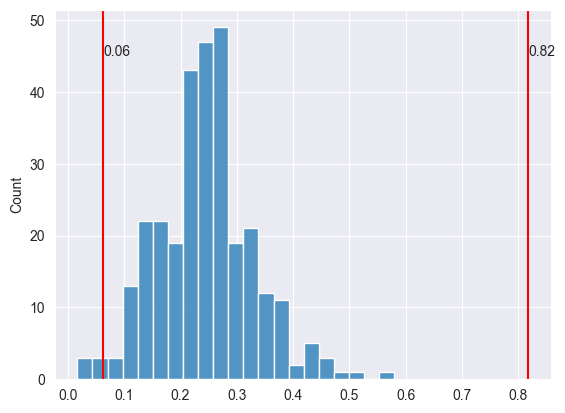

In [49]:
sns.histplot(cleared_data_df[cleared_data_df['ID'] == 'FLA-170']['rt'].to_numpy())
m = np.nanmean(np.log(cleared_data_df[cleared_data_df['ID'] == 'FLA-170']['rt'].to_numpy()))
sd = np.nanstd(np.log(cleared_data_df[cleared_data_df['ID'] == 'FLA-170']['rt'].to_numpy()))
ub = np.exp(m + 3*sd)
lb = np.exp(m - 3*sd)

plt.axvline(x=ub, c='red')
plt.axvline(x=lb, c='red')
plt.annotate(f'{round(lb,2)}', (lb, 45))
plt.annotate(f'{round(ub,2)}', (ub, 45))

plt.show()

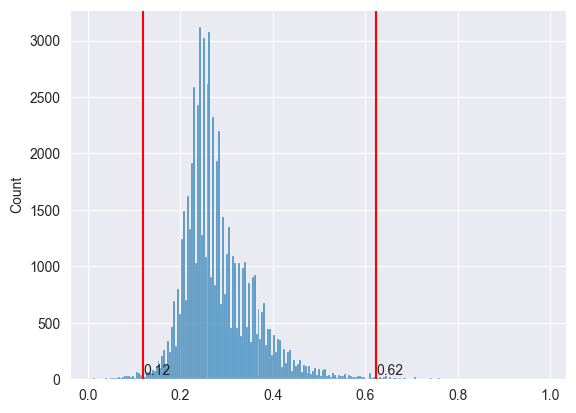

In [30]:
sns.histplot(cleared_data_df['rt'].to_numpy())
m = np.nanmean(np.log(cleared_data_df['rt'].to_numpy()))
sd = np.nanstd(np.log(cleared_data_df['rt'].to_numpy()))
ub = np.exp(m + 3*sd)
lb = np.exp(m - 3*sd)

plt.axvline(x=ub, c='red')
plt.axvline(x=lb, c='red')
plt.annotate(f'{round(lb,2)}', (lb, 45))
plt.annotate(f'{round(ub,2)}', (ub, 45))

plt.show()

In [31]:
cleared_data_df[cleared_data_df['rt'] > ub].groupby('ID').describe()['rt']

count      mean       std       min       25%       50%       75%  \
ID                                                                           
FLA-000    1.0  0.643885       NaN  0.643885  0.643885  0.643885  0.643885   
FLA-002   31.0  0.742507  0.094957  0.632583  0.656938  0.716593  0.799346   
FLA-003    1.0  0.667339       NaN  0.667339  0.667339  0.667339  0.667339   
FLA-005    3.0  0.709703  0.098386  0.639557  0.653471  0.667385  0.744776   
FLA-006    2.0  0.719447  0.063904  0.674260  0.696853  0.719447  0.742040   
...        ...       ...       ...       ...       ...       ...       ...   
FLA-213    5.0  0.662514  0.031155  0.639328  0.639759  0.643799  0.680936   
FLA-214    2.0  0.757671  0.176688  0.632734  0.695203  0.757671  0.820140   
FLA-216    1.0  0.698821       NaN  0.698821  0.698821  0.698821  0.698821   
FLA-219    1.0  0.632782       NaN  0.632782  0.632782  0.632782  0.632782   
FLA-221    3.0  0.682865  0.037437  0.639716  0.670941  0.702165  0.704440   

              max  
ID                 
FLA-000  0.643885  
FLA-002  0.965783  
FLA-003  0.667339  
FLA-005  0.822167  
FLA-006  0.764633  
...           ...  
FLA-213  0.708747  
FLA-214  0.882609  
FLA-216  0.698821  
FLA-219  0.632782  
FLA-221  0.706714  

[121 rows x 8 columns]

In [32]:
cleared_data_df[cleared_data_df['rt'] < lb].groupby('ID').describe()['rt']

count      mean       std       min       25%       50%       75%  \
ID                                                                           
FLA-004    1.0  0.111400       NaN  0.111400  0.111400  0.111400  0.111400   
FLA-005    9.0  0.095755  0.015076  0.076449  0.085535  0.090582  0.112517   
FLA-006    5.0  0.097864  0.017289  0.069705  0.097610  0.097902  0.111818   
FLA-009    1.0  0.118536       NaN  0.118536  0.118536  0.118536  0.118536   
FLA-012    4.0  0.097234  0.021397  0.072470  0.082808  0.100367  0.114794   
...        ...       ...       ...       ...       ...       ...       ...   
FLA-202    1.0  0.109852       NaN  0.109852  0.109852  0.109852  0.109852   
FLA-204    1.0  0.083688       NaN  0.083688  0.083688  0.083688  0.083688   
FLA-205    1.0  0.083429       NaN  0.083429  0.083429  0.083429  0.083429   
FLA-211   11.0  0.091140  0.013419  0.076387  0.083516  0.090509  0.094114   
FLA-215    2.0  0.099985  0.017937  0.087302  0.093644  0.099985  0.106327   

              max  
ID                 
FLA-004  0.111400  
FLA-005  0.118517  
FLA-006  0.112283  
FLA-009  0.118536  
FLA-012  0.115732  
...           ...  
FLA-202  0.109852  
FLA-204  0.083688  
FLA-205  0.083429  
FLA-211  0.118342  
FLA-215  0.112669  

[96 rows x 8 columns]

In [22]:
a = cleared_data_df.groupby('ID').describe()['rt']
a[a['mean'] < 0.36]

count      mean       std       min       25%       50%       75%  \
ID                                                                           
FLA-002  287.0  0.475285  0.124547  0.236425  0.403261  0.458511  0.528406   
FLA-032  292.0  0.364067  0.091471  0.229409  0.299015  0.327349  0.417066   
FLA-084  300.0  0.365335  0.107432  0.151053  0.287817  0.344205  0.431510   
FLA-086  295.0  0.466463  0.130288  0.215997  0.382464  0.444862  0.528571   
FLA-174  290.0  0.366295  0.135214  0.139772  0.265745  0.350042  0.437238   

              max  
ID                 
FLA-002  0.965783  
FLA-032  0.736633  
FLA-084  0.774134  
FLA-086  0.976433  
FLA-174  0.887326

## Test post-error adaptation

<Axes: xlabel='rt', ylabel='Count'>

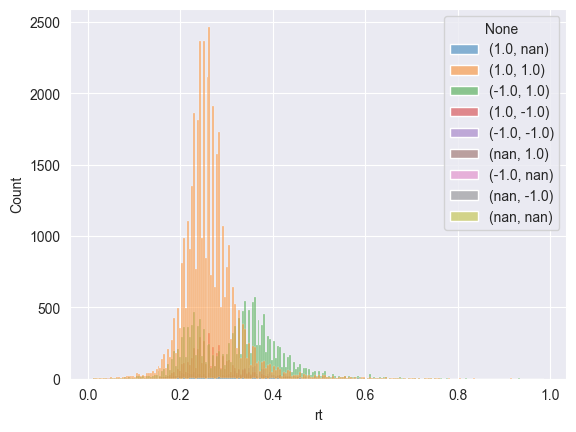

In [17]:
sns.histplot(
    test_df,
    x='rt',
    hue=test_df[['condition', 'pre_acc']].apply(tuple, axis=1),
)

/Users/anuszka/Projects/jointERR/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/Users/anuszka/Projects/jointERR/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/Users/anuszka/Projects/jointERR/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/Users/anuszka/Projects/jointERR/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/Users/anuszka/Projects/jointERR/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plo

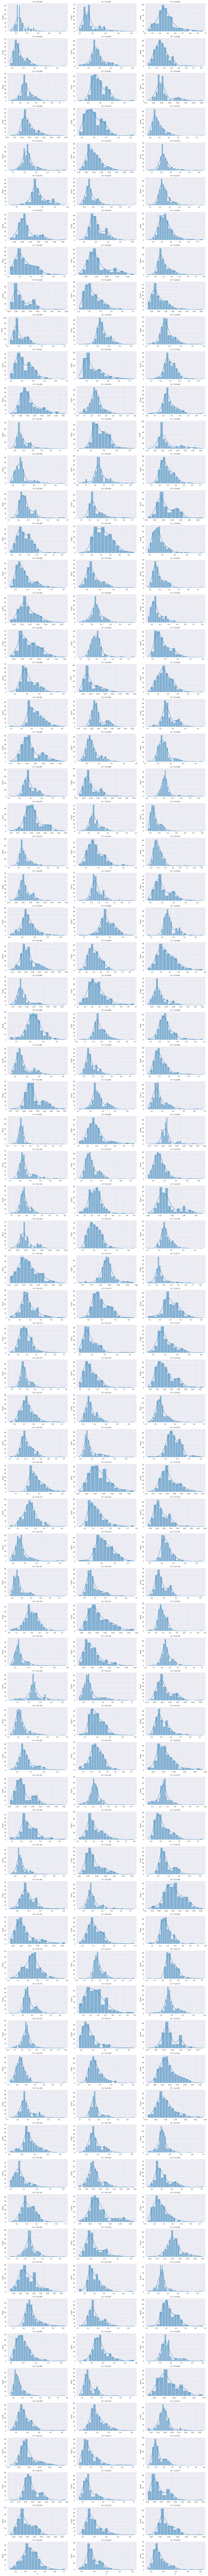

In [24]:
g = sns.FacetGrid(
    cleared_data_df.sort_values(['ID']),
    col="ID",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=2,
)

g.map_dataframe(
    sns.histplot,
    x="rt",
    # hue='pre_response',
    kde=True,
    palette='colorblind'
)

In [18]:
print(f"Mean post error RT: {np.mean(test_df[test_df['pre_acc'] == -1]['rt'])}")
print(f"Mean post correct RT: {np.mean(test_df[test_df['pre_acc'] == 1]['rt'])}")

print(f"Mean incongruent post error RT: {np.mean(test_df[(test_df['pre_acc'] == -1) & (test_df['condition'] == -1)]['rt'])}")
print(f"Mean incongruent post correct RT: {np.mean(test_df[(test_df['pre_acc'] == 1) & (test_df['condition'] == -1)]['rt'])}")

print(f"Mean congruent post error RT: {np.mean(test_df[(test_df['pre_acc'] == -1) & (test_df['condition'] == 1)]['rt'])}")
print(f"Mean congruent post correct RT: {np.mean(test_df[(test_df['pre_acc'] == 1) & (test_df['condition'] == 1)]['rt'])}")

Mean post error RT: 0.29252876677265055
Mean post correct RT: 0.28162759300550844
Mean incongruent post error RT: 0.3351876026231449
Mean incongruent post correct RT: 0.32159920569566475
Mean congruent post error RT: 0.27403523755836845
Mean congruent post correct RT: 0.2645499652129848


In [19]:
from scipy.stats import ttest_ind

print(f"post error vs post correct : {ttest_ind(test_df[test_df['pre_acc'] == -1]['rt'], test_df[test_df['pre_acc'] == 1]['rt'])}")
print(f"post error vs post correct in incongruent: {ttest_ind(test_df[(test_df['pre_acc'] == -1) & (test_df['condition'] == -1)]['rt'], test_df[(test_df['pre_acc'] == 1) & (test_df['condition'] == -1)]['rt'])}")

print(f"post error vs post correct in congruent: {ttest_ind(test_df[(test_df['pre_acc'] == -1) & (test_df['condition'] == 1)]['rt'], test_df[(test_df['pre_acc'] == 1) & (test_df['condition'] == 1)]['rt'])}")


post error vs post correct : TtestResult(statistic=nan, pvalue=nan, df=nan)
post error vs post correct in incongruent: TtestResult(statistic=nan, pvalue=nan, df=nan)
post error vs post correct in congruent: TtestResult(statistic=nan, pvalue=nan, df=nan)


#### Test ERN vs CRN

In [128]:
df_no_nans = test_df.dropna()

# check dataframe
display(df_no_nans.isnull().any())
display(df_no_nans)

trial_number               False
ID                         False
participant_index          False
condition                  False
condition_index            False
rt                         False
acc                        False
ne_Fz                      False
ne_FCz                     False
ne_mean_Fz                 False
ne_mean_FCz                False
y                          False
pre_ne_Fz                  False
pre_ne_FCz                 False
pre_ne_mean_Fz             False
pre_ne_mean_FCz            False
pre_acc                    False
rt_greater_than_1          False
log_rt_exceed_threshold    False
is_in_sequence             False
dtype: bool

trial_number   ID  participant_index  condition  condition_index  \
1                2  169                  1        1.0              1.0   
2                3  169                  1       -1.0              2.0   
3                4  169                  1        1.0              1.0   
4                5  169                  1       -1.0              2.0   
5                6  169                  1        1.0              1.0   
...            ...  ...                ...        ...              ...   
6895           296  208                 23       -1.0              2.0   
6896           297  208                 23       -1.0              2.0   
6897           298  208                 23        1.0              1.0   
6898           299  208                 23        1.0              1.0   
6899           300  208                 23       -1.0              2.0   

            rt  acc      ne_Fz     ne_FCz  ne_mean_Fz  ne_mean_FCz         y  \
1     0.309487  1.0  -0.501844  -2.783326    3.766289     9.476191  0.309487   
2     0.397239  1.0  -3.449400  -3.684688   -1.556821     2.632504  0.397239   
3     0.309485  1.0   0.790637   0.747574    4.928352     6.436701  0.309485   
4     0.386673  1.0  -2.980749  -5.791032   -0.957992    -1.689976  0.386673   
5     0.316943  1.0   2.572565  -1.050971    4.401086     7.993626  0.316943   
...        ...  ...        ...        ...         ...          ...       ...   
6895  0.239623 -1.0   8.320652   4.675662   12.951381    12.453468 -0.239623   
6896  0.382499  1.0   2.655430   4.103194    5.651438     9.170830  0.382499   
6897  0.236665  1.0  -5.139061  -4.319686   -0.687883    -0.221055  0.236665   
6898  0.261338  1.0   1.264665   0.551756    3.307084     4.809125  0.261338   
6899  0.208970 -1.0 -23.462593 -20.656988  -15.301127   -10.015849 -0.208970   

      pre_ne_Fz  pre_ne_FCz  pre_ne_mean_Fz  pre_ne_mean_FCz  pre_acc  \
1    -10.473746  -13.920862       -6.156650        -5.222685      1.0   
2     -0.501844   -2.783326        3.766289         9.476191      1.0   
3     -3.449400   -3.684688       -1.556821         2.632504      1.0   
4      0.790637    0.747574        4.928352         6.436701      1.0   
5     -2.980749   -5.791032       -0.957992        -1.689976      1.0   
...         ...         ...             ...              ...      ...   
6895   7.714413    8.938596       15.386128        15.872547      1.0   
6896   8.320652    4.675662       12.951381        12.453468     -1.0   
6897   2.655430    4.103194        5.651438         9.170830      1.0   
6898  -5.139061   -4.319686       -0.687883        -0.221055      1.0   
6899   1.264665    0.551756        3.307084         4.809125      1.0   

      rt_greater_than_1  log_rt_exceed_threshold  is_in_sequence  
1                 False                    False           False  
2                 False                    False           False  
3                 False                    False            True  
4                 False                    False            True  
5                 False                    False            True  
...                 ...                      ...             ...  
6895              False                    False            True  
6896              False                    False            True  
6897              False                    False           False  
6898              False                    False           False  
6899              False                    False            True  

[6858 rows x 20 columns]

In [63]:
threshold = 0.1
df_rts_truncated = df_no_nans[df_no_nans['rt'] > threshold]

df_rts_truncated

trial_number   ID  participant_index  condition  condition_index  \
1                2  169                  1        1.0              1.0   
2                3  169                  1       -1.0              2.0   
3                4  169                  1        1.0              1.0   
4                5  169                  1       -1.0              2.0   
5                6  169                  1        1.0              1.0   
...            ...  ...                ...        ...              ...   
6895           296  208                 23       -1.0              2.0   
6896           297  208                 23       -1.0              2.0   
6897           298  208                 23        1.0              1.0   
6898           299  208                 23        1.0              1.0   
6899           300  208                 23       -1.0              2.0   

            rt  acc      ne_Fz     ne_FCz  ne_mean_Fz  ne_mean_FCz         y  \
1     0.309487  1.0  -0.501844  -2.783326    3.766289     9.476191  0.309487   
2     0.397239  1.0  -3.449400  -3.684688   -1.556821     2.632504  0.397239   
3     0.309485  1.0   0.790637   0.747574    4.928352     6.436701  0.309485   
4     0.386673  1.0  -2.980749  -5.791032   -0.957992    -1.689976  0.386673   
5     0.316943  1.0   2.572565  -1.050971    4.401086     7.993626  0.316943   
...        ...  ...        ...        ...         ...          ...       ...   
6895  0.239623 -1.0   8.320652   4.675662   12.951381    12.453468 -0.239623   
6896  0.382499  1.0   2.655430   4.103194    5.651438     9.170830  0.382499   
6897  0.236665  1.0  -5.139061  -4.319686   -0.687883    -0.221055  0.236665   
6898  0.261338  1.0   1.264665   0.551756    3.307084     4.809125  0.261338   
6899  0.208970 -1.0 -23.462593 -20.656988  -15.301127   -10.015849 -0.208970   

      pre_ne_Fz  pre_ne_FCz  pre_ne_mean_Fz  pre_ne_mean_FCz  pre_acc  \
1    -10.473746  -13.920862       -6.156650        -5.222685      1.0   
2     -0.501844   -2.783326        3.766289         9.476191      1.0   
3     -3.449400   -3.684688       -1.556821         2.632504      1.0   
4      0.790637    0.747574        4.928352         6.436701      1.0   
5     -2.980749   -5.791032       -0.957992        -1.689976      1.0   
...         ...         ...             ...              ...      ...   
6895   7.714413    8.938596       15.386128        15.872547      1.0   
6896   8.320652    4.675662       12.951381        12.453468     -1.0   
6897   2.655430    4.103194        5.651438         9.170830      1.0   
6898  -5.139061   -4.319686       -0.687883        -0.221055      1.0   
6899   1.264665    0.551756        3.307084         4.809125      1.0   

      is_in_sequence  
1              False  
2              False  
3               True  
4               True  
5               True  
...              ...  
6895            True  
6896            True  
6897           False  
6898           False  
6899            True  

[6804 rows x 18 columns]

In [64]:
# df_rts_truncated['pre_ne_FCz_centered'] = (df_rts_truncated['pre_ne_FCz'] - np.mean(df_rts_truncated['pre_ne_FCz'])) / np.std(df_rts_truncated['pre_ne_FCz'])

y = df_rts_truncated['y'].to_numpy()
condition = df_rts_truncated['condition'].to_numpy()
pre_acc = df_rts_truncated['pre_acc'].to_numpy()
# pre_ne = df_rts_truncated['pre_ne_FCz_centered'].to_numpy()
participant_index = df_rts_truncated['participant_index'].to_numpy()

n_participants = len(np.unique(participant_index))
n_conditions = len(np.unique(condition))

participants_trials_slices = []
pre_ne = []
for index in np.unique(participant_index):
    indices = np.where(participant_index == index)[0]
    start_index = indices[0] + 1
    end_index = indices[-1] + 1
    participants_trials_slices.append([start_index, end_index])

    participants_ne = df_rts_truncated.iloc[indices]['pre_ne_FCz'].to_numpy().flatten()
    participants_ne_stand = (participants_ne - np.mean(participants_ne)) / np.std(participants_ne)

    pre_ne.extend(participants_ne_stand)

participants_trials_slices = np.array(participants_trials_slices)
pre_ne = np.array(pre_ne)
df_rts_truncated['pre_ne_FCz_centered'] = pre_ne

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_71952/3074861894.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rts_truncated['pre_ne_FCz_centered'] = pre_ne


Group-level stats and distributions

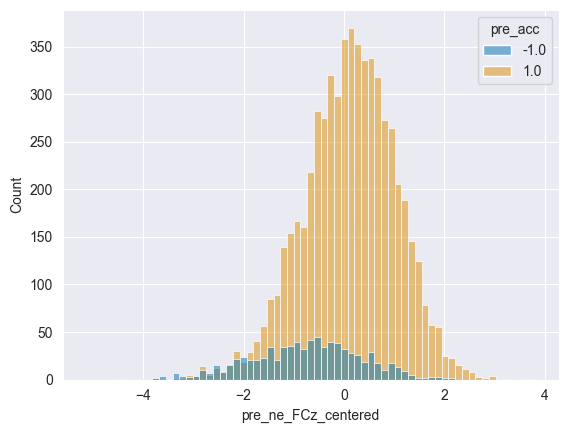

In [65]:
plt.figure()

sns.histplot(
    df_rts_truncated,
    x="pre_ne_FCz_centered",
    hue='pre_acc',
    palette='colorblind'
)

plt.show()

In [66]:
test_2 = df_rts_truncated.dropna()
ttest_ind(test_2[test_2['pre_acc'] == -1]['pre_ne_FCz'], test_2[test_2['pre_acc'] == 1]['pre_ne_FCz'])

TtestResult(statistic=-21.420122189414126, pvalue=1.4753946666107116e-98, df=6802.0)

Participant-level stats and distributions

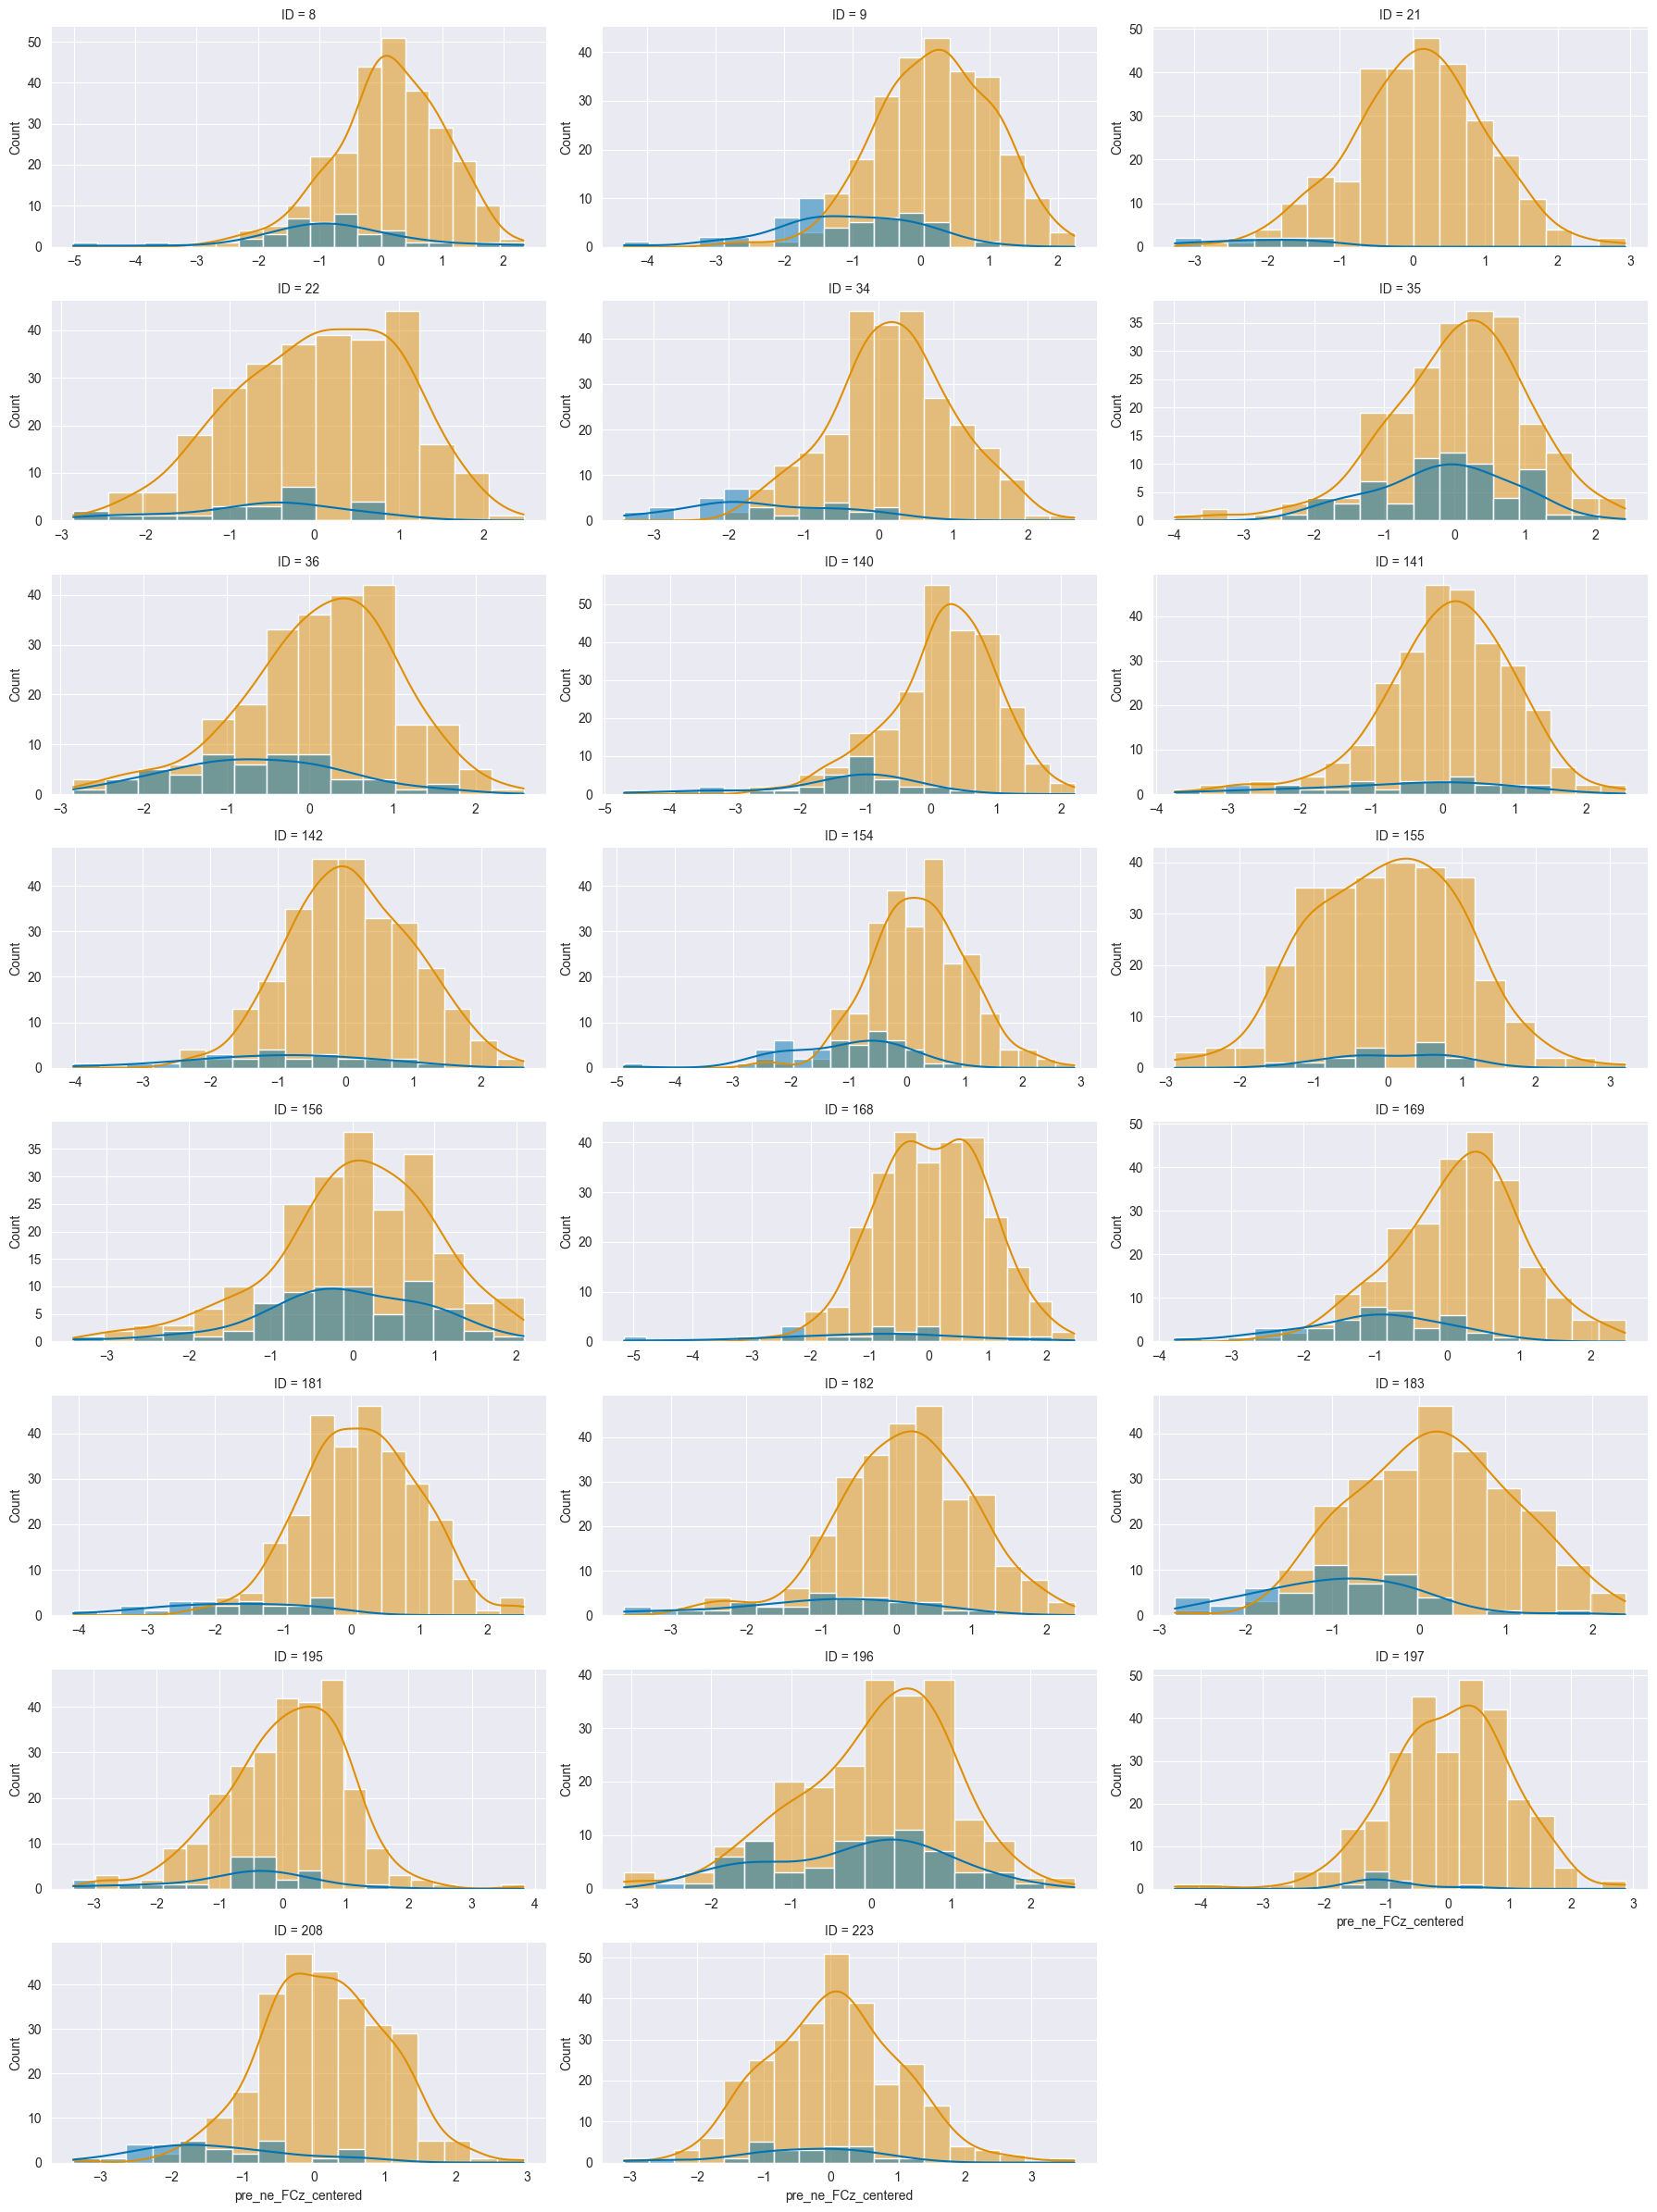

In [67]:
g = sns.FacetGrid(
    df_rts_truncated.sort_values(['ID']),
    col="ID",
    col_wrap=3,
    sharex=False,
    sharey=False,
    aspect=2,
)

g.map_dataframe(
    sns.histplot,
    x="pre_ne_FCz_centered",
    hue='pre_acc',
    kde=True,
    palette='colorblind'
)

#### Test post-response adaptation and links with pre-trial accuracy and brain signal

In [68]:
import statsmodels.formula.api as smf

test_df2 = test_df.dropna()
test_df2['rt'] = test_df2['rt']*1000
mod = smf.ols(formula='rt ~ pre_acc', data=test_df2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.84
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           2.43e-05
Time:                        23:01:22   Log-Likelihood:                -39651.
No. Observations:                6859   AIC:                         7.931e+04
Df Residuals:                    6857   BIC:                         7.932e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    289.6841      1.465    197.768      0.0

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_71952/2184364754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['rt'] = test_df2['rt']*1000


In [70]:
import statsmodels.formula.api as smf

test_df2 = test_df.dropna()
test_df2['rt'] = test_df2['rt']*1000
test_df2['pre_ne_FCz_centered'] = test_df2['pre_ne_FCz'] - np.mean(test_df2['pre_ne_FCz'])

mod = smf.ols(formula='rt ~ pre_ne_FCz_centered*condition', data=test_df2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     306.8
Date:                Mon, 05 Feb 2024   Prob (F-statistic):          6.67e-187
Time:                        23:01:29   Log-Likelihood:                -39228.
No. Observations:                6859   AIC:                         7.846e+04
Df Residuals:                    6855   BIC:                         7.849e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_71952/1119672488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['rt'] = test_df2['rt']*1000
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_71952/1119672488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['pre_ne_FCz_centered'] = test_df2['pre_ne_FCz'] - np.mean(test_df2['pre_ne_FCz'])


In [71]:
import statsmodels.formula.api as smf

test_df2 = test_df.dropna()
test_df2['rt'] = test_df2['rt']*1000
test_df2['pre_ne_FCz_centered'] = test_df2['pre_ne_FCz'] - np.mean(test_df2['pre_ne_FCz'])

mod = smf.ols(formula='rt ~ pre_ne_FCz_centered + pre_ne_FCz_centered*condition + C(pre_acc) + C(pre_acc)*condition + pre_ne_FCz_centered*C(pre_acc) + pre_ne_FCz_centered*C(pre_acc)*condition', data=test_df2)
res = mod.fit()

# print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     rt   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     135.7
Date:                Mon, 05 Feb 2024   Prob (F-statistic):          7.50e-188
Time:                        23:01:40   Log-Likelihood:                -39215.
No. Observations:                6859   AIC:                         7.845e+04
Df Residuals:                    6851   BIC:                         7.850e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_71952/673595589.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['rt'] = test_df2['rt']*1000
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_71952/673595589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['pre_ne_FCz_centered'] = test_df2['pre_ne_FCz'] - np.mean(test_df2['pre_ne_FCz'])


In [146]:
# test_df.to_csv('data/twentythree_participants_post_eeg_test_set_with_sequence_global_rt_thresholds.csv')